# Blood Pressure

In [1]:
import json
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import arviz as az
import pymc3 as pm
import xarray as xr

import matplotlib.pyplot as plt
from plotnine import *

%load_ext dotenv
%dotenv
PROJECT_DIR=Path(os.environ.get('PROJECT_DIR'))
sys.path.append(str(PROJECT_DIR))

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

theme_set(theme_bw())
pd.set_option('display.max_columns', 100)
# working with arviz structure?
SEED = 1925

DATA_FILEPATH = PROJECT_DIR / 'data'  / 'blood-pressure' 
DATA_FILEPATH

PosixPath('/media/david/T7/code/bmcp/bmcp-notes/data/blood-pressure')

# Background
+ Collected every morning and night 6 April - 12 April 2023
+ Automated machine < $50
+ Machine detects incorrect strap tightness and errors out
+ Cannot find repeatability/accuracy data on machine, but [this](https://www.health.harvard.edu/blog/home-blood-pressure-monitors-arent-accurate-201410297494)
+ table below from [How Accurate Are Home Blood Pressure Devices in Use? A Cross-Sectional Study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4889144/)

In [3]:
day_num = np.array([[d]*2 for d in range(0,7)]).flatten()
systolic = [118, 171, 159, 156, 122, 155, 129, 152, 116, 148, 133, 145, 131, 124]
diastolic = [88, 77, 75, 73, 86, 74, 64, 73, 67, 69, 75, 76, 76, 62]
heart_rate = [68, 54, 58, 58, 63, 57, 62, 55, 57, 57, 57, 57, 67, 68]
tod = ['AM', 'PM']*7
tod
df = pd.DataFrame({'day': day_num, 'tod': tod, 'systolic': systolic, 'diastolic': diastolic, 'heart_rate': heart_rate})
df = pd.melt(df, id_vars=['day', 'tod']).rename(columns={'variable': 'measure'})
df['measure'] = df['measure'].astype('category')
df.head()

,day,tod,measure,value
0,0,AM,systolic,118
1,0,PM,systolic,171
2,1,AM,systolic,159
3,1,PM,systolic,156
4,2,AM,systolic,122


In [4]:
df.groupby('measure')['value'].describe()

,count,mean,std,min,25%,50%,75%,max
measure,,,,,,,,
diastolic,14.0,73.928571,7.226706,62.0,70.00,74.5,76.00,88.0
heart_rate,14.0,59.857143,4.833491,54.0,57.00,57.5,62.75,68.0
systolic,14.0,139.928571,17.380202,116.0,125.25,139.0,154.25,171.0


In [5]:
df.groupby(['tod', 'measure'])['value'].describe()

count        mean        std    min    25%    50%    75%  \
tod measure                                                                
AM  diastolic     7.0   75.857143   8.858679   64.0   71.0   75.0   81.0   
    heart_rate    7.0   61.714286   4.608481   57.0   57.5   62.0   65.0   
    systolic      7.0  129.714286  14.465065  116.0  120.0  129.0  132.0   
PM  diastolic     7.0   72.000000   5.099020   62.0   71.0   73.0   75.0   
    heart_rate    7.0   58.000000   4.618802   54.0   56.0   57.0   57.5   
    systolic      7.0  150.142857  14.205968  124.0  146.5  152.0  155.5   

                  max  
tod measure            
AM  diastolic    88.0  
    heart_rate   68.0  
    systolic    159.0  
PM  diastolic    77.0  
    heart_rate   68.0  
    systolic    171.0

# Population Data

<img src="img/Ecosh_Blood_Pressure_Chart.jpg" alt="isolated" width="600"/>

# Data Distributions

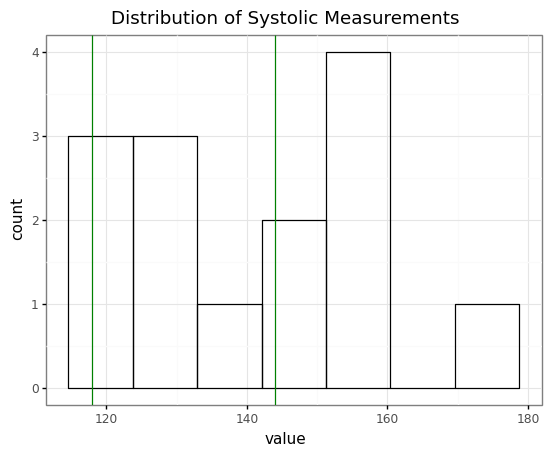

In [6]:
syst = df[df['measure']=='systolic']
p = (ggplot(syst, aes('value')) +
     geom_histogram(bins=7, fill='none', color='black') +
     geom_vline(xintercept=118, color='green') +
     geom_vline(xintercept=144, color='green') +
     labs(title='Distribution of Systolic Measurements')
    )
p.draw();

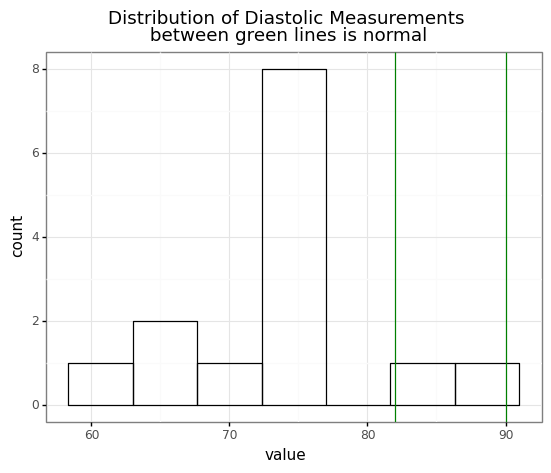

In [7]:
dia = df[df['measure']=='diastolic']
p = (ggplot(dia, aes('value')) +
     geom_histogram(bins=7, fill='none', color='black') +
     geom_vline(xintercept=82, color='green') +
     geom_vline(xintercept=90, color='green') +
     labs(title='Distribution of Diastolic Measurements\n between green lines is normal')
    )
p.draw();

# Model Setup
### Priors - from chart showing normal levels

+ Female is non-smoker, not overweight, and in good health, so I think a reasonable prior would be the standard normal blood pressure range for her age group
+ For female Age 55 -59 From blood pressure table (below)
+ systolic
    + min 118
    + max 144
    + normal 131 (midpoint of min/max)
+ diastolic
    + min 82
    + max 90
    + normal 86 (midpoint of minmax)
+ The priors could be uniform, but maybe a better model would be a normally distributed parameter for the mean, or maybe a students t distribution.

### Data Model

+ We could assume that having bought the cheapest possible testing machine from Amazon, and based on the previously cited article, a significant proportion of the variation is from measurement error
+ We could assume that the instrument is unbiased, but has high variation around the true reading.
+ Therefore, we could run the data through a model to get an estimate of the mean blood pressure over the period, and compare this to the healthy limits.
+ There are only 14 values, so it is difficult to form a valid distribution. However, we could assume the measurement error is normally distributed measurement error. From this viewpoint, the data shows as normally distributed with a sigma close to the sigma of the actual data. 

# Model

In [8]:
df.head()

,day,tod,measure,value
0,0,AM,systolic,118
1,0,PM,systolic,171
2,1,AM,systolic,159
3,1,PM,systolic,156
4,2,AM,systolic,122


## Uniform Priors

In [44]:
# from bmcp book - chapter 3 listing 3.4 nocovariate_mass
all_measures = df['measure']

with pm.Model() as sys_model_uni_prior:
    sys_mu = pm.Uniform('sys_mu', 110, 152)
    sys_sigma = pm.Uniform('sys_sigma', 10, 18)
    # 
    sys = pm.Normal("sys", mu=sys_mu, sigma=sys_sigma, observed = df[df['measure']=='systolic']['value'])
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample()
    idata_sys_model_uni_prior = az.from_pymc3(trace=trace, prior=prior)

/tmp/ipykernel_751579/1397521072.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sys_sigma, sys_mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8793791838510722, but should be close to 0.8. Try to increase the number of tuning steps.


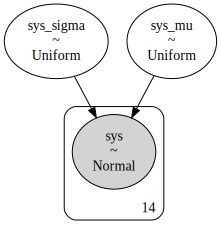

In [45]:
pm.model_to_graphviz(sys_model_uni_prior)

In [46]:
idata_sys_model_uni_prior

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

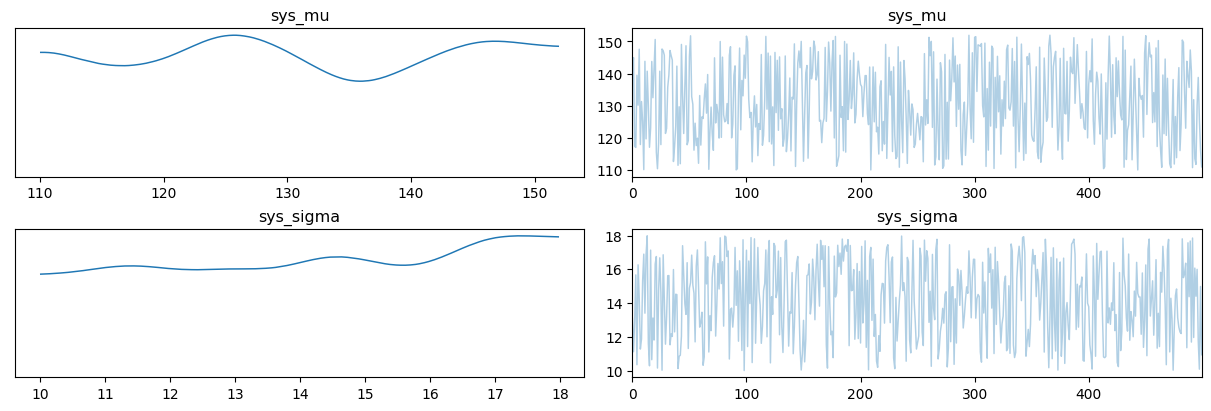

In [47]:
az.plot_trace(idata_sys_model_uni_prior.prior, var_names=['sys_mu', 'sys_sigma']);

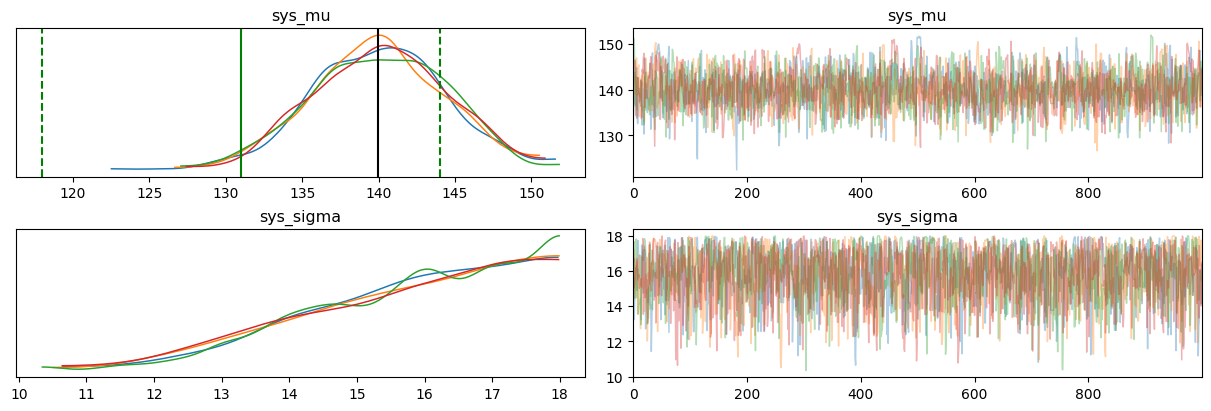

In [48]:
axes = az.plot_trace(idata_sys_model_uni_prior, compact=False);
axes[:, 0][0].axvline(118, color='green', linestyle='dashed')
axes[:, 0][0].axvline(144, color='green', linestyle='dashed')
axes[:, 0][0].axvline(131, color='green', linestyle='solid')
axes[:, 0][0].axvline(syst['value'].mean(), color='black')
plt.show();

## Normal prior

In [49]:
all_measures = df['measure']

with pm.Model() as sys_model_normal_prior:
    sys_mu = pm.Normal('sys_mu', 131, 15.0)
    # sys_sigma = pm.HalfStudentT('sys_sigma', 1, 3)
    sys_sigma = pm.Uniform('sys_sigma', 10, 18)
    # 
    sys = pm.Normal("sys", mu=sys_mu, sigma=sys_sigma, observed = df[df['measure']=='systolic']['value'])
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample()
    idata_sys_model_normal_prior = az.from_pymc3(trace=trace, prior=prior)

/tmp/ipykernel_751579/462271282.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sys_sigma, sys_mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


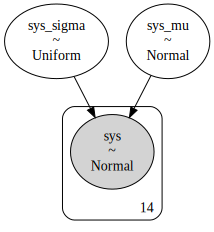

In [50]:
pm.model_to_graphviz(sys_model_normal_prior)

In [51]:
idata_sys_model_normal_prior

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

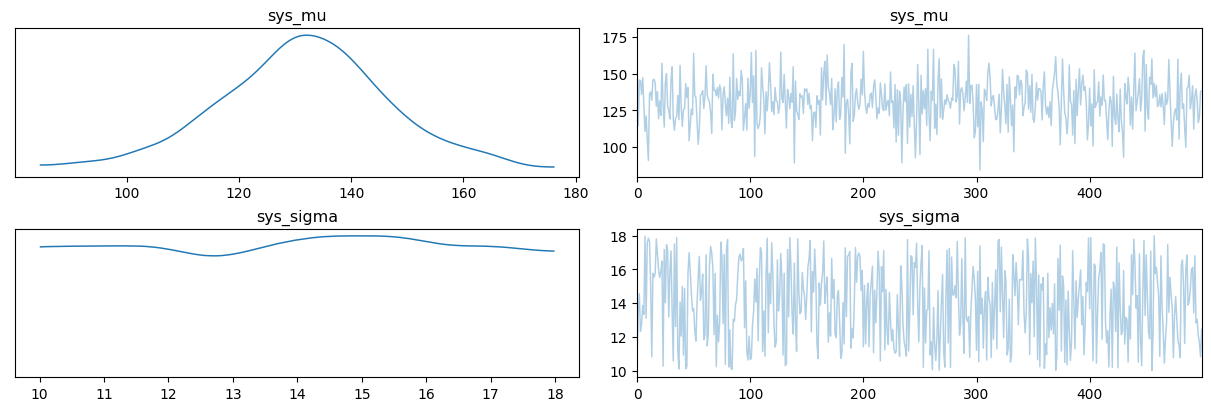

In [52]:
az.plot_trace(idata_sys_model_normal_prior.prior, var_names=['sys_mu', 'sys_sigma']);

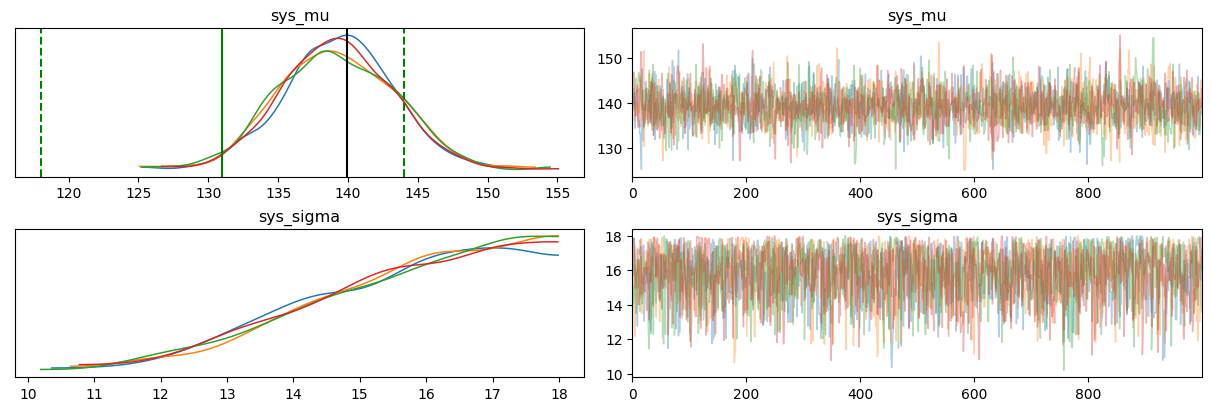

In [53]:
axes = az.plot_trace(idata_sys_model_normal_prior, compact=False);
axes[:, 0][0].axvline(118, color='green', linestyle='dashed')
axes[:, 0][0].axvline(144, color='green', linestyle='dashed')
axes[:, 0][0].axvline(131, color='green', linestyle='solid')
axes[:, 0][0].axvline(syst['value'].mean(), color='black')
plt.show();

# Comments
+ more questions than answers here
+ halfStudentT - not sure how to paramaterize this
+ Dramatic impact from priors on this small set of data
+ Which is the right prior set?
+ If we are assuming measurement error is unbiased, then most likely the most appropriate prior give a posterior distribution for mu that is located at about the same point as the data mean.
+ Now really confused - how to set parameters on the priors for this small data set